In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import math
# importar future
from __future__ import print_function

In [12]:
class WeatherData(Dataset):
    def __init__(self,future=0):
        self.data = pd.read_csv('DataSQL/raw_data_sinaica.csv')
        #self.data = self.data.dropna()
        # rellenar los datos con promedios moviles o interpolaciones
        self.data = self.data.interpolate()
        self.data['Time'] = pd.to_datetime(self.data['Time'])
        self.data = self.data.sort_values(by=['Estación','Time'])
        self.data = self.data.set_index('Time')
        self.Municipios = self.data['Estación'].unique()
        self.Mundicc = {}
        # hacer un diccionario para el nombre de los municipios
        for i in range(len(self.Municipios)):
            self.Mundicc[self.Municipios[i]] = i
        # Aplicar el diccionario al dataframe
        self.data['Estación'] = self.data['Estación'].map(self.Mundicc)
        for col in self.data.columns:
            self.data = self.data[self.data[col]>=0]
        # numpy array
        # agarrar solo datos de la estacion 0
        self.data = self.data[self.data['Estación'] == 0]
        # quitar columna estacíon
        self.data = self.data.drop(columns=['Estación'])
        self.columns = self.data.columns
        # standarizar los datos
        self.mean = self.data.mean()
        self.std = self.data.std()
        self.data = (self.data - self.mean)/self.std
        # correjir los NaN
        self.data = self.data.fillna(0)
        print (self.data.columns)
        self.data = self.data.to_numpy()
        # convertir los numeros menores a 0 en 
        self.x = torch.tensor(self.data[:-1], dtype=torch.float)
        self.y = torch.tensor(self.data[1:], dtype=torch.float)
        self.set_future(future)
    def set_future(self, future):
        self.future = future
    def __len__(self):
        return len(self.data)-self.future-1

    def __getitem__(self, idx):
        return self.x[idx].unsqueeze(0),self.y[idx].unsqueeze(0)
    def get_batch(self, batch_size, future = 0):
        idx = np.random.randint(0, len(self.data)-future-1, batch_size)
        return self.x[idx],self.y[idx+future]

In [8]:
def LinearCell(num_input, num_hidden, Dropout=0.1):
    Seq = nn.Sequential(
        nn.Linear(num_input,num_hidden),
        nn.LeakyReLU(0.8),
        nn.Dropout(Dropout)
    )
    return Seq

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [10]:

class Net(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers, num_linear =1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers)
        LinearSeq = []
        for i in range(num_linear):
            LinearSeq.append(LinearCell(hidden_size,hidden_size,Dropout=0))
        self.LinearSeq = nn.Sequential(*LinearSeq)
        self.L1 = LinearCell(hidden_size,hidden_size,Dropout=0)
        self.L2 = LinearCell(hidden_size,hidden_size,Dropout=0)
        self.LOut = LinearCell(hidden_size,output_size,Dropout=0)
        self.init_weights()
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.normal_(m.bias)
    def forward(self,x,future=0):
        # outputs
        outputs = []
        h_t = torch.zeros(self.num_layers,1,self.hidden_size)
        c_t = torch.zeros(self.num_layers,1,self.hidden_size)
        
        for input_t in x.split(1,dim=0):
            out, (h_t,c_t) = self.lstm1(input_t,(h_t,c_t))
            #print (out.shape)
            out = self.LinearSeq(out)
            l1 = self.L1(out)
            l2 = self.L2(l1)
            output = self.LOut(l2)
            outputs.append(output)
        
        for i in range(future):
            out, (h_t,c_t) = self.lstm1(output, (h_t,c_t))
            out = self.LinearSeq(out)
            l1 = self.L1 (out)
            l2 = self.L2(l1)
            output = self.LOut(l2)
            outputs.append(output)
        outputs = torch.cat(outputs,dim=0)
        return outputs

In [13]:
# pararmetros del entrenamiento
learning_rate = .001
num_epochs = 1000
batch_size = 240
clip = .5
future = 100
Prediction_weight = 1.2
dataset = WeatherData()
Batch_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

Index(['CO', 'DV', 'HR', 'NO', 'NO2', 'NOx', 'O3', 'PB', 'PM10', 'PM2.5', 'PP',
       'RS', 'SO2', 'TMP', 'VV'],
      dtype='object')


In [7]:
# take a sample
batch = next(iter(Batch_loader))
print (batch[0].shape)

torch.Size([240, 1, 15])


In [18]:
input_size = dataset.columns.__len__()
max_lenght = 48
argument = {
    'input_size' : input_size,
    'hidden_size' : 18,
    'output_size' : input_size,
    'num_layers' : 3,
    'num_linear' : 2
}
Predictor = Net(**argument)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Predictor.parameters(), lr=learning_rate)

In [19]:
# cargar los pesos
Predictor.load_state_dict(torch.load('Model/Ideal.pt'))

<All keys matched successfully>

In [9]:
sample_t = torch.zeros(1,1,input_size)
output = Predictor(sample_t)
print (output.shape)

torch.Size([1, 1, 15])


In [31]:
from tqdm  import tqdm
import matplotlib.pyplot as plt

def test(Predictor,test_data,size,future=60,it = 0):
    iterat = DataLoader(test_data, batch_size=size, shuffle=False)
    iterat = iter(iterat)
    for i in range(it):
        (x,y) = next(iterat)
        print (x.shape)
    out = Predictor(x[:-future],future=future)
    Y_proyectado = out.detach().numpy()[:,0,7]
    Y_real = y.detach().numpy()[:,0,7]
    plt.plot(Y_real,label='Real')
    plt.plot(Y_proyectado,label='Prediccion')
    plt.axvline(x=size-future, color='black', linestyle='--')
    plt.legend()
    plt.show()

In [11]:
#min_loss = 0.24296
min_loss = 0.19

In [12]:
# load checkpoint
Predictor.load_state_dict(torch.load('Model/Ideal.pt'))

<All keys matched successfully>

Epoch: 0 Loss: 0.28021:   0%|          | 0/1000 [00:09<?, ?it/s]

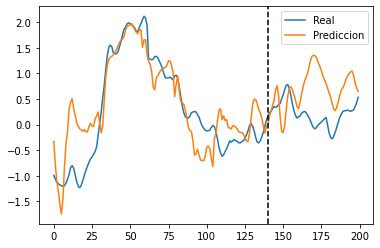

Epoch: 5 Loss: 0.25552:   0%|          | 5/1000 [00:51<2:14:11,  8.09s/it]

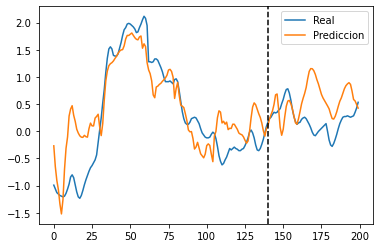

Epoch: 10 Loss: 0.24734:   1%|          | 10/1000 [01:29<2:08:13,  7.77s/it]

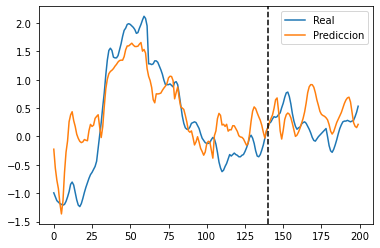

Epoch: 15 Loss: 0.24116:   2%|▏         | 15/1000 [02:15<2:05:53,  7.67s/it]

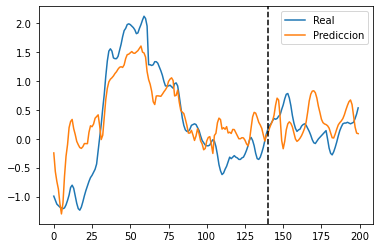

Epoch: 20 Loss: 0.23477:   2%|▏         | 20/1000 [04:32<6:16:15, 23.04s/it]

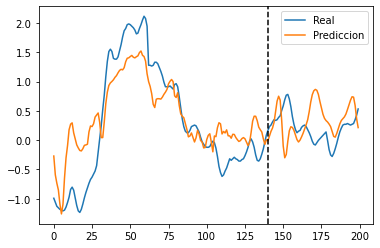

Epoch: 25 Loss: 0.23540:   2%|▎         | 25/1000 [06:26<6:08:13, 22.66s/it]

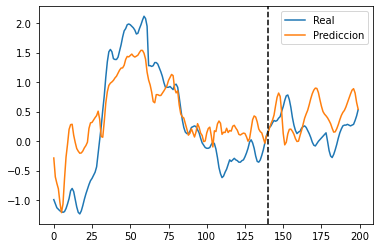

Epoch: 30 Loss: 0.23322:   3%|▎         | 30/1000 [07:54<4:57:06, 18.38s/it]

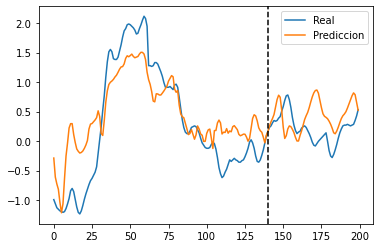

Epoch: 30 Loss: 0.23322:   3%|▎         | 31/1000 [07:57<4:08:44, 15.40s/it]


KeyboardInterrupt: 

In [30]:
progress = tqdm(range(num_epochs))
outputs = torch.zeros(1,max_lenght,input_size)
for epoch in progress:
    mean_loss = 0.0
    for _,(x,y) in enumerate(Batch_loader):
        if x.shape[0] < batch_size:
            continue
        #print (y.shape)
        out = Predictor(x[:-future],future=future)
        teached_out = out[:-future]
        predicted_out = out[-future:]
        teached_loss = criterion(teached_out,y[:-future])
        predicted_loss = criterion(predicted_out,y[-future:])
        loss = ((teached_loss*0.4) + (predicted_loss * 0.6)) / 2
        if torch.cuda.is_available():
            loss = loss.cuda()
        mean_loss += loss
    mean_loss = mean_loss / len(Batch_loader)
    optimizer.zero_grad()
    mean_loss.backward()
    #torch.nn.utils.clip_grad_norm_(Predictor.parameters(), clip)
    optimizer.step()
    progress.set_description("Epoch: {} Loss: {:.5f}".format(epoch,mean_loss))
    if mean_loss.item() < min_loss and mean_loss.item() > 0:
        min_loss = mean_loss.item()
        # save checkpoint
        torch.save(Predictor.state_dict(), 'Model/Checkpoint.pt')

    if epoch % 5 == 0:
        test(Predictor,dataset,200,future=60,it=1)

In [79]:
print ('Minimo Loss: ',min_loss)

Minimo Loss:  0.23191717267036438


In [22]:
# guardar el modelo
torch.save(Predictor.state_dict(), 'Model/Ideal.pt')

torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])
torch.Size([460, 1, 15])


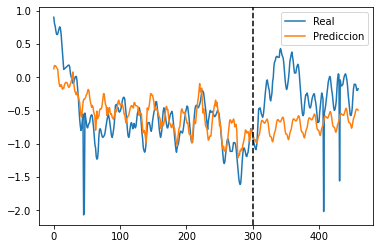

In [32]:
context = 300 
pred = 160
test(Predictor,dataset,context+pred,future=pred,it=7)

In [14]:
# make a function to predict same as test, but generate 100 generations and print the mean and std
def predict(Predictor,test_data,size,future=60,it = 0, gens = 100):
    iterat = DataLoader(test_data, batch_size=size, shuffle=False)
    iterat = iter(iterat)
    for i in range(it):
        (x,y) = next(iterat)
    outputs = []
    for i in range(gens):
        out = Predictor(x[:-future],future=future)
        Y_proyectado = out.detach().numpy()[:,0,0]
        outputs.append(Y_proyectado)
        Y_real = y.detach().numpy()[:,0,0]
    outputs = np.array(outputs)
    mean = outputs.mean(axis=0)
    std = outputs.std(axis=0)
    # dont print the results of the prediction before the axvline
    plt.plot(Y_real,label='Real')
    plt.plot(mean,label='Prediccion')
    plt.fill_between(np.arange(mean.shape[0]),mean-std,mean+std,alpha=0.5)
    plt.axvline(x=size-future, color='black', linestyle='--')
    plt.legend()
    plt.show()

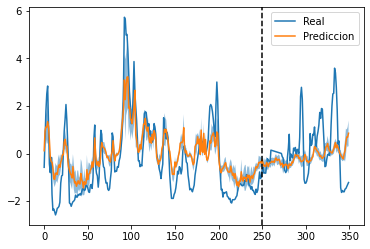

In [32]:
predict(Predictor,dataset,350,future=100,it=1,gens=10)